In [0]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [0]:
# Loading Datasets on to DataFrames
indicators_url = 'https://github.com/chc5/education-indicator-analysis/raw/master/2018_all_indicators.csv'
education_url = 'https://github.com/chc5/education-indicator-analysis/raw/master/adult_education_level.csv'

inds_df = pd.read_csv(indicators_url)
ed_df = pd.read_csv(education_url)

# Column 9999 in the Indicators Dataset only shows the latest value from the data drawn within 1990 to 2017.
# In order to detect education system growth predictors this column is unneccessary.
inds_df = inds_df.drop(columns=['9999'])

In [67]:
# Many indicators from 1990 to 2017 that only have at most one or two recordings for a specific indicators.
# These recordings may or may not indicate growth over the years which will not contribute to our analysis.
# These indicators will be dropped.
# When threshold = 1, it removed 25636 - 20588 = 5048 / 25636 = 20% of the indicators
threshold = 0
drop_stack = set()
print(len(inds_df))
for index, row in inds_df.iterrows():
#     print(row['1990':].count())
    if row['1990':].count() <= threshold:
        drop_stack.add(index)
inds_df = inds_df.drop(drop_stack)
print(len(inds_df))


25636
22918


In [0]:
# Get the missing values at each year and return the array of years (aka. column)
def get_missing_yearly_values(row):
    row_df = row.to_frame().reset_index()
    row_df = row_df.drop(range(5))
    row_df.columns = ['x', 'y']
    missing_X = row_df[row_df['y'].isnull()].x
    return missing_X

# Predicting the missing values using Linear Regression Models
# and then filling out the missing values based on the model
year_columns = inds_df.columns.values[5:]
for index, row in inds_df.iterrows():
    missing_years = get_missing_yearly_values(row).values
    # If there are nothing to fill out then we don't need to model it out.
    if missing_years.size <= 0:
        continue
    row = row.drop(missing_years)
    row = row.drop(['dimension', 'indicator_id', 'indicator_name', 'iso3', 'country_name'])
    value = row.values.reshape(-1, 1)
    year = year_columns
    # The difference set of total years and missing years are the years where there are recorded values.
    year = np.setdiff1d(year, missing_years).astype(int).reshape(-1, 1)
    missing_years = missing_years.astype(int)
    missing_years = missing_years.reshape(missing_years.shape[0],-1)
    
    reg = LinearRegression()
    reg.fit(year, value)
    missing_values = reg.predict(missing_years)
    # Filling out the missing data
    for i in range(len(missing_years)):
        inds_df.at[index, str(missing_years[i][0])] = missing_values[i][0]
        

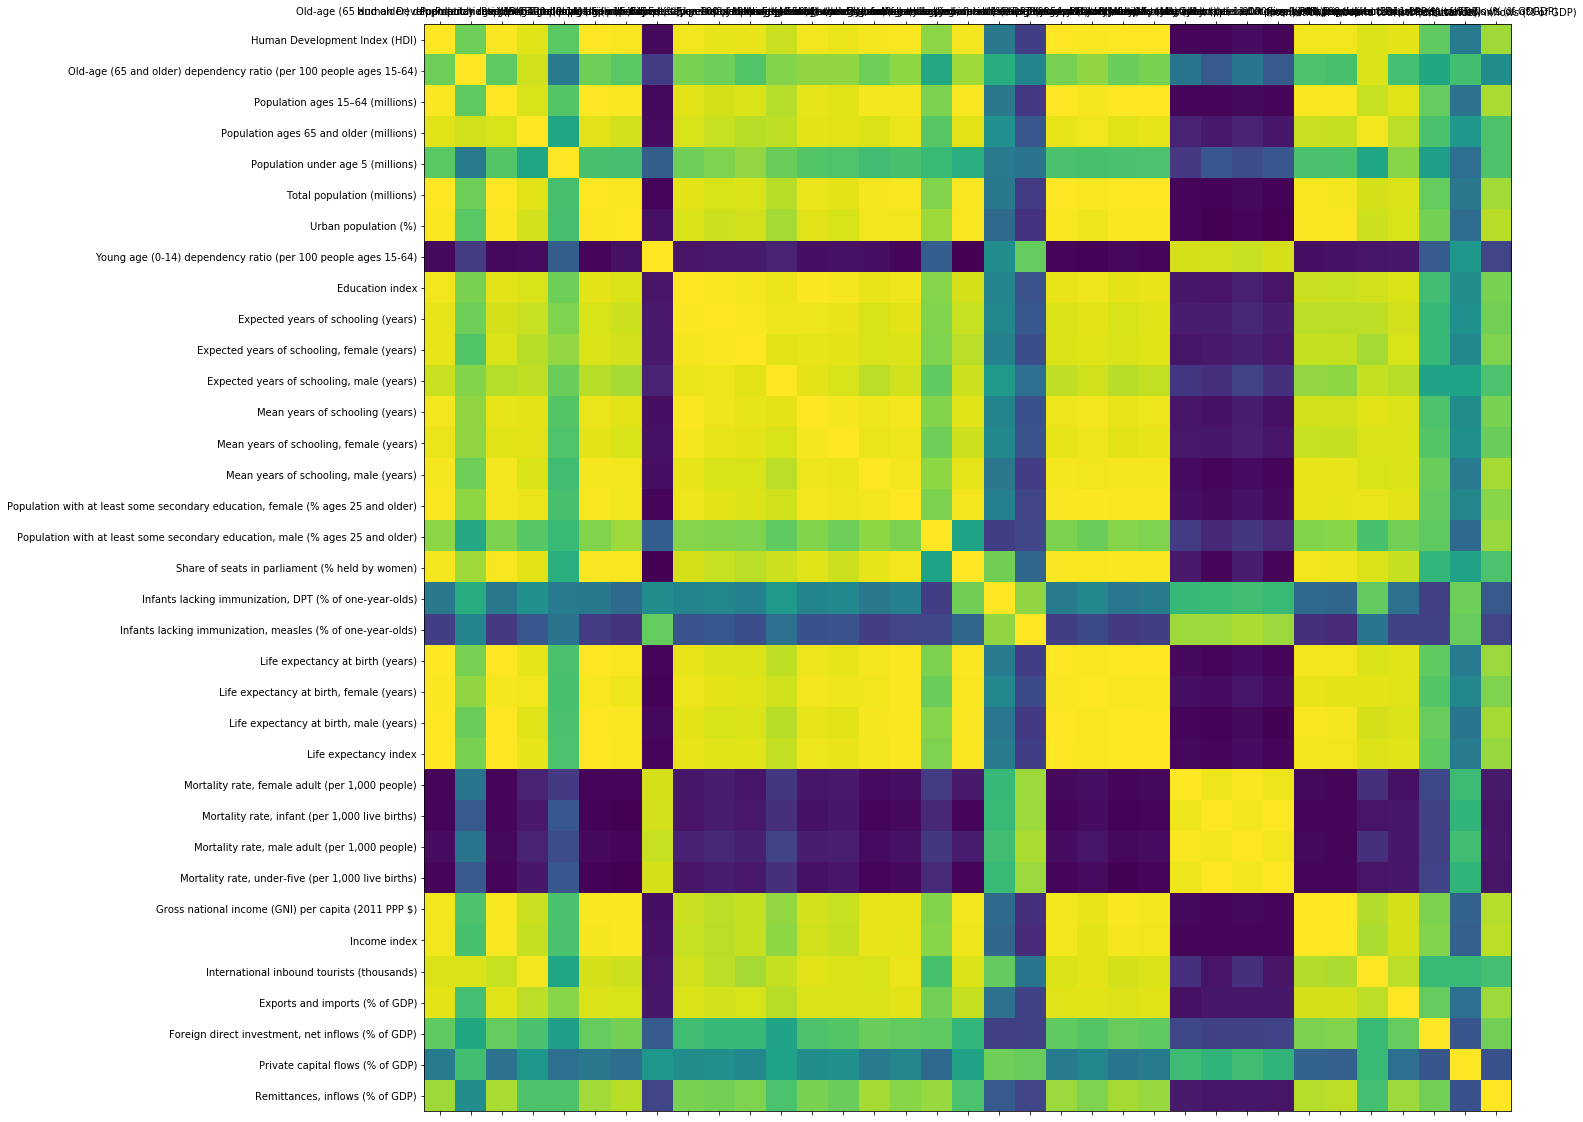

In [18]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
country_names = inds_df.country_name.unique()
  
def plot_corr_country(df, country):
  # drop ids etc., get only rows with country, transpose
  df_corr = inds_df.drop(df.columns[[0, 1, 3]], axis=1)[df.country_name == country].T
  # fix columns
  df_corr.columns = df_corr.iloc[0]
  # drop first two rops
  df_corr = df_corr[2:]
  # df_corr = inds_df.drop(inds_df.columns[[0, 1, 3]], axis=1).drop(inds_df.columns[range(5,32)], axis=1)[inds_df.country_name == "Albania"]
  df_corr = df_corr.apply(pd.to_numeric)
  return df_corr
  

# change threshold to get more columns 
df_corr = plot_corr_country(inds_df, "United States")
plot_corr(df_corr, size=20)

In [5]:
def strongest_indicators(df_corr, num_indicators):
    possible_strongest = []
    for row in df_corr.corr():
        #corr_dict.update(row = df_corr.corr()[row])
        possible_strongest.append([row, df_corr.corr()[row]['Education index']])
        possible_strongest.sort(key = 
                                    lambda corr: corr[1])
    #gets rid of the correlation with the same feature
    possible_strongest = possible_strongest[:-1]
    return possible_strongest[len(possible_strongest)-num_indicators:len(possible_strongest)]

potential_indicators = strongest_indicators(df_corr, 10)

def check_corr(df_corr, potential_indicators, target_feature):
    features_ex = [indicator[0] for indicator in potential_indicators]
    features_ex.remove(target_feature)
    for feature in features_ex:
        if df_corr.corr()[target_feature][feature] > 0.95:
            return False
    return True

potential_ret_val = []
for indicator_pair in potential_indicators:
    potential_ret_val.append(check_corr(df_corr, potential_indicators, indicator_pair[0]))
print(potential_ret_val)

#def check_independence(potential_indicators):
    
    
        

[False, False, False, False, False, False, False, False, False, False]


In [6]:
df_corr.corr()

indicator_name,Human Development Index (HDI),Old-age (65 and older) dependency ratio (per 100 people ages 15-64),Population ages 15–64 (millions),Population ages 65 and older (millions),Population under age 5 (millions),Total population (millions),Urban population (%),Young age (0-14) dependency ratio (per 100 people ages 15-64),Education index,Expected years of schooling (years),...,"Mortality rate, infant (per 1,000 live births)","Mortality rate, male adult (per 1,000 people)","Mortality rate, under-five (per 1,000 live births)",Gross national income (GNI) per capita (2011 PPP $),Income index,International inbound tourists (thousands),Exports and imports (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Private capital flows (% of GDP),"Remittances, inflows (% of GDP)"
indicator_name,,,,,,,,,,,,,,,,,,,,,
Human Development Index (HDI),1.000000,0.561934,0.988785,0.905013,0.491210,0.992437,0.979007,-0.948025,0.956854,0.927807,...,-0.968877,-0.931759,-0.971677,0.959559,0.955214,0.885389,0.920062,0.515629,-0.180500,0.712734
Old-age (65 and older) dependency ratio (per 100 people ages 15-64),0.561934,1.000000,0.503312,0.852551,-0.172902,0.563382,0.488395,-0.648901,0.601153,0.555902,...,-0.432128,-0.222314,-0.437533,0.446016,0.418747,0.886225,0.407151,0.199689,0.398810,-0.016595
Population ages 15–64 (millions),0.988785,0.503312,1.000000,0.880536,0.465118,0.996834,0.986647,-0.956143,0.909749,0.874412,...,-0.966952,-0.949805,-0.970517,0.981584,0.978036,0.831351,0.901678,0.524954,-0.235928,0.750528
Population ages 65 and older (millions),0.905013,0.852551,0.880536,1.000000,0.179633,0.911636,0.864750,-0.933704,0.876553,0.830116,...,-0.860020,-0.794606,-0.865221,0.839361,0.822314,0.965739,0.801836,0.428335,0.071437,0.445198
Population under age 5 (millions),0.491210,-0.172902,0.465118,0.179633,1.000000,0.422118,0.414675,-0.387999,0.557484,0.616266,...,-0.455835,-0.531760,-0.457099,0.425557,0.429605,0.184755,0.641601,0.128006,-0.263647,0.439301
Total population (millions),0.992437,0.563382,0.996834,0.911636,0.422118,1.000000,0.988437,-0.959376,0.919131,0.880560,...,-0.973580,-0.947890,-0.976907,0.977276,0.972589,0.873620,0.898129,0.531209,-0.201063,0.724490
Urban population (%),0.979007,0.488395,0.986647,0.864750,0.414675,0.988437,1.000000,-0.907346,0.888890,0.848864,...,-0.993811,-0.970479,-0.995347,0.984923,0.985889,0.845909,0.876406,0.584027,-0.285873,0.787877
Young age (0-14) dependency ratio (per 100 people ages 15-64),-0.948025,-0.648901,-0.956143,-0.933704,-0.387999,-0.959376,-0.907346,1.000000,-0.889933,-0.855877,...,0.864999,0.835250,0.872412,-0.914872,-0.899777,-0.882026,-0.866469,-0.414378,0.066765,-0.574736
Education index,0.956854,0.601153,0.909749,0.876553,0.557484,0.919131,0.888890,-0.889933,1.000000,0.987044,...,-0.886273,-0.815522,-0.888269,0.839075,0.832772,0.858239,0.888913,0.389217,-0.008419,0.596206


In [0]:
df_corr.corr().info()

<class 'pandas.core.frame.DataFrame'>
Index: 35 entries, Human Development Index (HDI) to Remittances, inflows (% of GDP)
Data columns (total 35 columns):
Human Development Index (HDI)                                                      35 non-null float64
Old-age (65 and older) dependency ratio (per 100 people ages 15-64)                35 non-null float64
Population ages 15–64 (millions)                                                   35 non-null float64
Population ages 65 and older (millions)                                            35 non-null float64
Population under age 5 (millions)                                                  35 non-null float64
Total population (millions)                                                        35 non-null float64
Urban population (%)                                                               35 non-null float64
Young age (0-14) dependency ratio (per 100 people ages 15-64)                      35 non-null float64
Education index      

In [0]:
#df_corr.corr()['Old-age (65 and older) dependency ratio (per 100 people ages 15-64)']['Human Development Index (HDI)']
df_corr.corr()['Old-age (65 and older) dependency ratio (per 100 people ages 15-64)']

indicator_name
Human Development Index (HDI)                                                      0.561934
Old-age (65 and older) dependency ratio (per 100 people ages 15-64)                1.000000
Population ages 15–64 (millions)                                                   0.503312
Population ages 65 and older (millions)                                            0.852551
Population under age 5 (millions)                                                 -0.172902
Total population (millions)                                                        0.563382
Urban population (%)                                                               0.488395
Young age (0-14) dependency ratio (per 100 people ages 15-64)                     -0.648901
Education index                                                                    0.601153
Expected years of schooling (years)                                                0.555902
Expected years of schooling, female (years)                      

In [0]:
df_corr.corr().keys()

Index(['Human Development Index (HDI)',
       'Old-age (65 and older) dependency ratio (per 100 people ages 15-64)',
       'Population ages 15–64 (millions)',
       'Population ages 65 and older (millions)',
       'Population under age 5 (millions)', 'Total population (millions)',
       'Urban population (%)',
       'Young age (0-14) dependency ratio (per 100 people ages 15-64)',
       'Education index', 'Expected years of schooling (years)',
       'Expected years of schooling, female (years)',
       'Expected years of schooling, male (years)',
       'Mean years of schooling (years)',
       'Mean years of schooling, female (years)',
       'Mean years of schooling, male (years)',
       'Population with at least some secondary education, female (% ages 25 and older)',
       'Population with at least some secondary education, male (% ages 25 and older)',
       'Share of seats in parliament (% held by women)',
       'Infants lacking immunization, DPT (% of one-year-olds)',


In [0]:
len(df_corr.corr())

35

In [0]:
#list containing sublist first value is key second is 
corr_x = []
for row in df_corr.corr():
    #corr_dict.update(row = df_corr.corr()[row])
    corr_x.append([row, df_corr.corr()[row]['Education index']])
corr_x.sort(key = 
             lambda corr: corr[1])
#gets rid of the correlation with the same feature
corr_x = corr_x[:-1]

print(corr_x)

[['Mortality rate, under-five (per 1,000 live births)', -0.8957301801890567], ['Mortality rate, infant (per 1,000 live births)', -0.8939259309172504], ['Young age (0-14) dependency ratio (per 100 people ages 15-64)', -0.8899332554336324], ['Mortality rate, female adult (per 1,000 people)', -0.8861986066255351], ['Mortality rate, male adult (per 1,000 people)', -0.8429782691031374], ['Infants lacking immunization, measles (% of one-year-olds)', -0.48092306585261724], ['Infants lacking immunization, DPT (% of one-year-olds)', -0.09184661807705537], ['Private capital flows (% of GDP)', -0.008418543365733009], ['Foreign direct investment, net inflows (% of GDP)', 0.38921651219583736], ['Population under age 5 (millions)', 0.5574842754950077], ['Remittances, inflows (% of GDP)', 0.5962059359960289], ['Old-age (65 and older) dependency ratio (per 100 people ages 15-64)', 0.6011532700567224], ['Population with at least some secondary education, male (% ages 25 and older)', 0.6400665480528305]

Human Development Index (HDI)
Old-age (65 and older) dependency ratio (per 100 people ages 15-64)
Population ages 15–64 (millions)
Population ages 65 and older (millions)
Population under age 5 (millions)
Total population (millions)
Urban population (%)
Young age (0-14) dependency ratio (per 100 people ages 15-64)
Education index
Expected years of schooling (years)
Expected years of schooling, female (years)
Expected years of schooling, male (years)
Mean years of schooling (years)
Mean years of schooling, female (years)
Mean years of schooling, male (years)
Population with at least some secondary education, female (% ages 25 and older)
Population with at least some secondary education, male (% ages 25 and older)
Share of seats in parliament (% held by women)
Infants lacking immunization, DPT (% of one-year-olds)
Infants lacking immunization, measles (% of one-year-olds)
Life expectancy at birth (years)
Life expectancy at birth, female (years)
Life expectancy at birth, male (years)
Life

In [0]:
df_corr.corr()['Human Development Index (HDI)']['Education index']

0.9568539316505816

In [0]:
potential_indicators

[['Life expectancy at birth (years)', 0.9314780436034437],
 ['Life expectancy index', 0.9350690218123131],
 ['Expected years of schooling, male (years)', 0.9453969782985058],
 ['Population with at least some secondary education, female (% ages 25 and older)',
  0.9473475068134908],
 ['Life expectancy at birth, female (years)', 0.9481973326342565],
 ['Human Development Index (HDI)', 0.9568539316505816],
 ['Mean years of schooling, female (years)', 0.9696290590871636],
 ['Expected years of schooling, female (years)', 0.9718754613066345],
 ['Mean years of schooling (years)', 0.9848881294837082],
 ['Expected years of schooling (years)', 0.9870438737592965]]

In [7]:
def check_corr(df_corr, potential_indicators, target_feature):
    features_ex = [indicator[0] for indicator in potential_indicators]
    features_ex.remove(target_feature)
    for feature in features_ex:
        if df_corr.corr()[target_feature][feature] > 0.95:
            return False
    return True

potential_ret_val = []
for indicator_pair in potential_indicators:
    potential_ret_val.append(check_corr(df_corr, potential_indicators, indicator_pair[0]))
print(potential_ret_val)
#print([indicator[0] for indicator in potential_indicators])
#print([indicator[0] for indicator in potential_indicators].remove('Expected years of schooling (years)'))
#check_corr(df_corr, potential_indicators, 'Expected years of schooling (years)')
#for indicator_pair in potential_indicators:
    

[False, False, False, False, False, False, False, False, False, False]


In [0]:
df_corr.corr()['Mean years of schooling (years)']['Life expectancy at birth (years)']

0.9499836748084022

In [0]:
def get_xy_lists(xkey, ykey, inds_df):
  comparematrix = [[],[]]
  print(comparematrix)
  for i in country_names :
    df_corr = plot_corr_country(inds_df, i)
    if xkey in df_corr :
      for yearnum in range(2015, 2016):
        year = str(yearnum)
        try :
          if not np.isnan(float(df_corr[xkey].loc[year])):
            comparematrix[0].append(float(df_corr[xkey].loc[year]))
            comparematrix[1].append(float(df_corr[ykey].loc[year]))
            break
        except KeyError as e :
          if len(comparematrix[0]) > len(comparematrix[1]) :
            comparematrix[0].pop()
          elif len(comparematrix[1]) > len(comparematrix[0]) :
            comparematrix[1].pop()
          break
  return comparematrix

[[], []]


Text(0, 0.5, 'Mean years of schooling (years)')

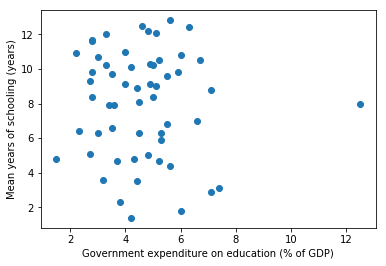

In [117]:
xkey = 'Government expenditure on education (% of GDP)'
ykey = 'Mean years of schooling (years)'
comparematrix = get_xy_lists(xkey, ykey, inds_df)
plt.scatter(comparematrix[0], comparematrix[1])
plt.xlabel(xkey)
plt.ylabel(ykey)

[[], []]


Text(0, 0.5, 'Programme for International Student Assessment (PISA) score in mathematics')

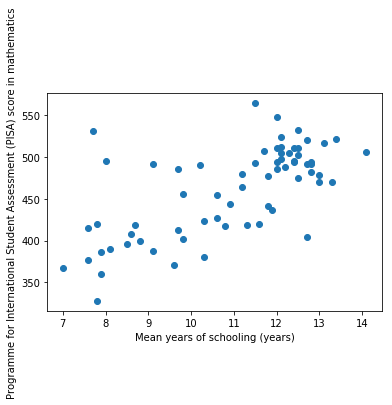

In [109]:
ykey = 'Programme for International Student Assessment (PISA) score in mathematics'
xkey = 'Mean years of schooling (years)'
comparematrix = get_xy_lists(xkey, ykey, inds_df)
plt.scatter(comparematrix[0], comparematrix[1])
plt.xlabel(xkey)
plt.ylabel(ykey)

[[], []]


Text(0, 0.5, 'Mean years of schooling (years)')

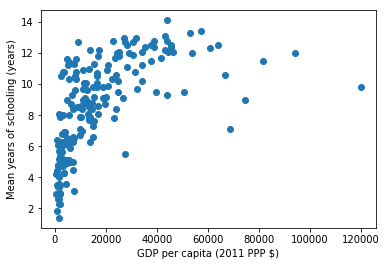

In [114]:
xkey = 'GDP per capita (2011 PPP $)'
ykey = 'Mean years of schooling (years)'
comparematrix = get_xy_lists(xkey, ykey, inds_df)
plt.scatter(comparematrix[0], comparematrix[1])
plt.xlabel(xkey)
plt.ylabel(ykey)

[[], []]


Text(0, 0.5, 'Programme for International Student Assessment (PISA) score in mathematics')

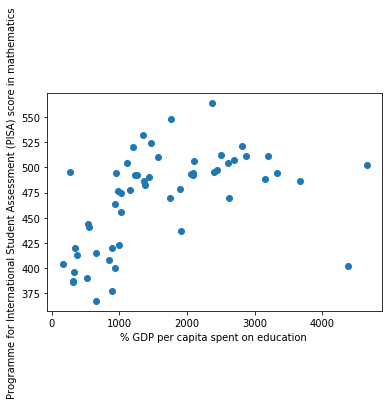

In [106]:
def get_xy_gdp(ykey, inds_df):
  xkey1 = 'GDP per capita (2011 PPP $)'
  xkey2 = 'Government expenditure on education (% of GDP)'
  xkey3 = 'Total population (millions)'
  comparematrix = [[],[]]
  print(comparematrix)
  for i in country_names :
    df_corr = plot_corr_country(inds_df, i)
    if xkey in df_corr :
      for yearnum in range(2012, 2016):
        year = str(yearnum)
        try :
          if not np.isnan(float(df_corr[xkey].loc[year])):
            #print((float(df_corr[xkey1].loc[year])/100) * float(df_corr[xkey2].loc[year]) * float(df_corr[xkey3].loc[year]))
            comparematrix[0].append(float(df_corr[xkey1].loc[year]) * float(df_corr[xkey2].loc[year])/100)
            comparematrix[1].append(float(df_corr[ykey].loc['2015']))
            break
        except KeyError as e :
          if len(comparematrix[0]) > len(comparematrix[1]) :
            comparematrix[0].pop()
          elif len(comparematrix[1]) > len(comparematrix[0]) :
            comparematrix[1].pop()
          break
  return comparematrix

ykey = 'Programme for International Student Assessment (PISA) score in mathematics'
comparematrix = get_xy_gdp(ykey, inds_df)
plt.scatter(comparematrix[0], comparematrix[1])
plt.xlabel('% GDP per capita spent on education ')
plt.ylabel(ykey)
#df_corr = plot_corr_country(inds_df, "Argentina")
#print(df_corr[ykey])